In [2]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#constants
omega = smp.symbols("ω")
eps = smp.symbols("Ɛ")
#variables
q1, q2, p1, p2 = smp.symbols("q_1 q_2 p_1 p_2")
theta, I = smp.symbols('θ I')

$$
H = \frac{p_1^2}{2} - cos(q_1) + \frac{1}{2}(p_2^2 + \omega^2 q_2^2) + \frac{\epsilon}{2} (q_1 - q_2)^2 
$$

$$
h = \frac{p_1^2}{2} - cos(q_1) + \omega I + \frac{\epsilon}{2} \left( q_1 - \sqrt{\frac{2 I}{\omega}} \sin(\theta) \right)^2
$$

O sistema tem comportamento de um oscilador harmonico amortecido. Também tem orbitas quasi-periodicas no pendulo.

In [4]:
H = (p1**2)/2 - smp.cos(q1) + 1/2*(p2**2 + omega**2 * q2**2) + (eps/2)*(q1 - q2)**2
f = (p1**2)/2 - smp.cos(q1) 
g = I*omega
h1 = (eps/2)*(q1 - smp.sqrt((2*I)/omega)*smp.sin(theta))**2
h = f+g+h1

In [4]:
f1 = smp.lambdify((omega, eps, q1,q2,p1,p2),-H.diff(q1),"numpy") #p_dot
f2 = smp.lambdify((omega, eps, q1,q2,p1,p2),-H.diff(q2),"numpy")
f3 = smp.lambdify((omega, eps, q1,q2,p1,p2),H.diff(p1),"numpy") #q_dot
f4 = smp.lambdify((omega, eps, q1,q2,p1,p2),H.diff(p2),"numpy")

In [5]:
def EqMotion(t,x, omega, eps):
    q1, q2, p1, p2 = x
    dp1 = f1(omega,eps,q1,q2,p1,p2)
    dp2 = f2(omega,eps,q1,q2,p1,p2)
    dq1 = f3(omega,eps,q1,q2,p1,p2)
    dq2 = f4(omega,eps,q1,q2,p1,p2)
    return [dq1, dq2, dp1, dp2]

In [5]:
from scipy.integrate import solve_ivp

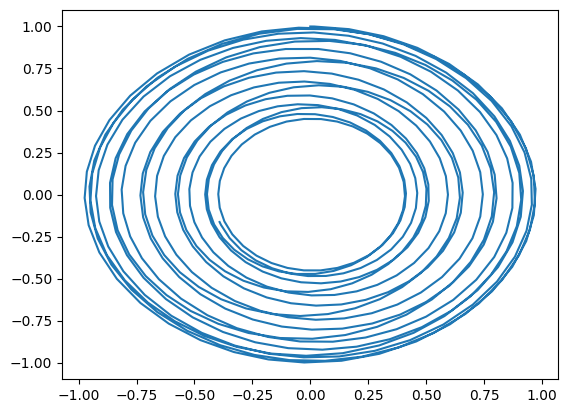

In [50]:
t_span = (0,100)
y0 = [0, 0, 1, -1]

solution = solve_ivp(EqMotion, t_span, y0, args=[1, 1/15], rtol = 10e-8, atol = 10e-8)
if solution.status == 0:
    plt.plot(solution.y[0], solution.y[2])

Solução do oscilador harmonico:
$$\begin{gather}
    q_2 = \sqrt{\frac{2I}{\omega}} \sin(\theta) \\
    p_2 = \sqrt{2I \omega} \cos(\theta)
\end{gather}
$$

Pelo metodo de Melnikov o sistema vai ser caotico quando a energia passar de h>f, quando f é o hamiltoniano do pendulo simples nas separatrizes. Portanto é bom abusar do fato que as soluções da sepatrix são periodicas para o angulo e sempre as mesmas para os momentos. Portanto as condições iniciais devem ser geradas para $(I, \theta)$, e assumindo que $\omega > 0$

Sessão de poicaré pra quando $q_2 = 0$. Mas isso significa na verdade uma sessão pra quando $\sin(\theta) = 0$

In [6]:
#defining the equations for the hamiltonian with action-angle variables.
f1 = smp.lambdify((omega, eps, q1,theta,p1,I),-h.diff(q1),"numpy") #p_dot
f2 = smp.lambdify((omega, eps, q1,theta,p1,I),-h.diff(theta),"numpy")
f3 = smp.lambdify((omega, eps, q1,theta,p1,I), h.diff(p1),"numpy") #q_dot
f4 = smp.lambdify((omega, eps, q1,theta,p1,I), h.diff(I),"numpy")

def AA_equation(t,y, omega, eps):
    q1, theta, p1, I = y
    dp1 = f1(omega,eps,q1,theta,p1,I)
    dI = f2(omega,eps,q1,theta,p1,I)
    dq1 = f3(omega,eps,q1,theta,p1,I)
    dtheta = f4(omega,eps,q1,theta,p1,I)
    return [dq1, dtheta, dp1, dI]

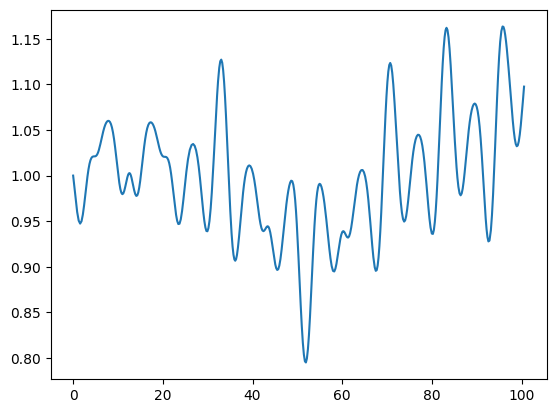

In [7]:
t_span = (0,100)
y0 = [-np.pi, 0, 0, 1]

solution = solve_ivp(AA_equation, t_span, y0, args=[1, 1/100], rtol = 10e-8, atol = 10e-8)
if solution.status == 0:
    plt.plot(solution.y[1], solution.y[3])

In [8]:
def section(t,y,omega,eps): #defining the section for q_2 = 0.
    return np.sin(y[1])

In [9]:
rng = np.random.default_rng()
Is = rng.uniform(1.0,2.0, 10)

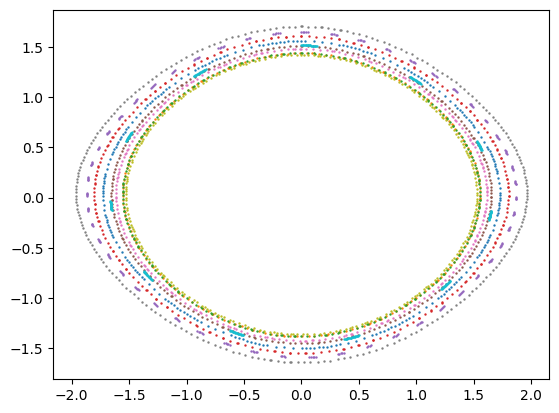

In [10]:
section.terminal = False
section.direction = 1

conds = []
omega = 0.5
E = 1.0

for I in Is: 
    conds.append([0, 0, np.sqrt(2)*np.sqrt(E+1.0 - omega*I), I])

fig, ax = plt.subplots(1, 1)

for cond in conds:
    solution = solve_ivp(AA_equation, [0, 3000], cond, args=[omega, 1/100], rtol = 10e-10, atol = 10e-10, events=section)
    if solution.y_events != None: 
        ax.scatter(*solution.y_events[0][:, 0::2].T, s=0.5)